In [1059]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
CALIBRATION_DIR = os.path.abspath("camera_cal")
CALIBRATION_FILE = "camera_calibration.npy"
TEST_DIR = os.path.abspath("test_images")

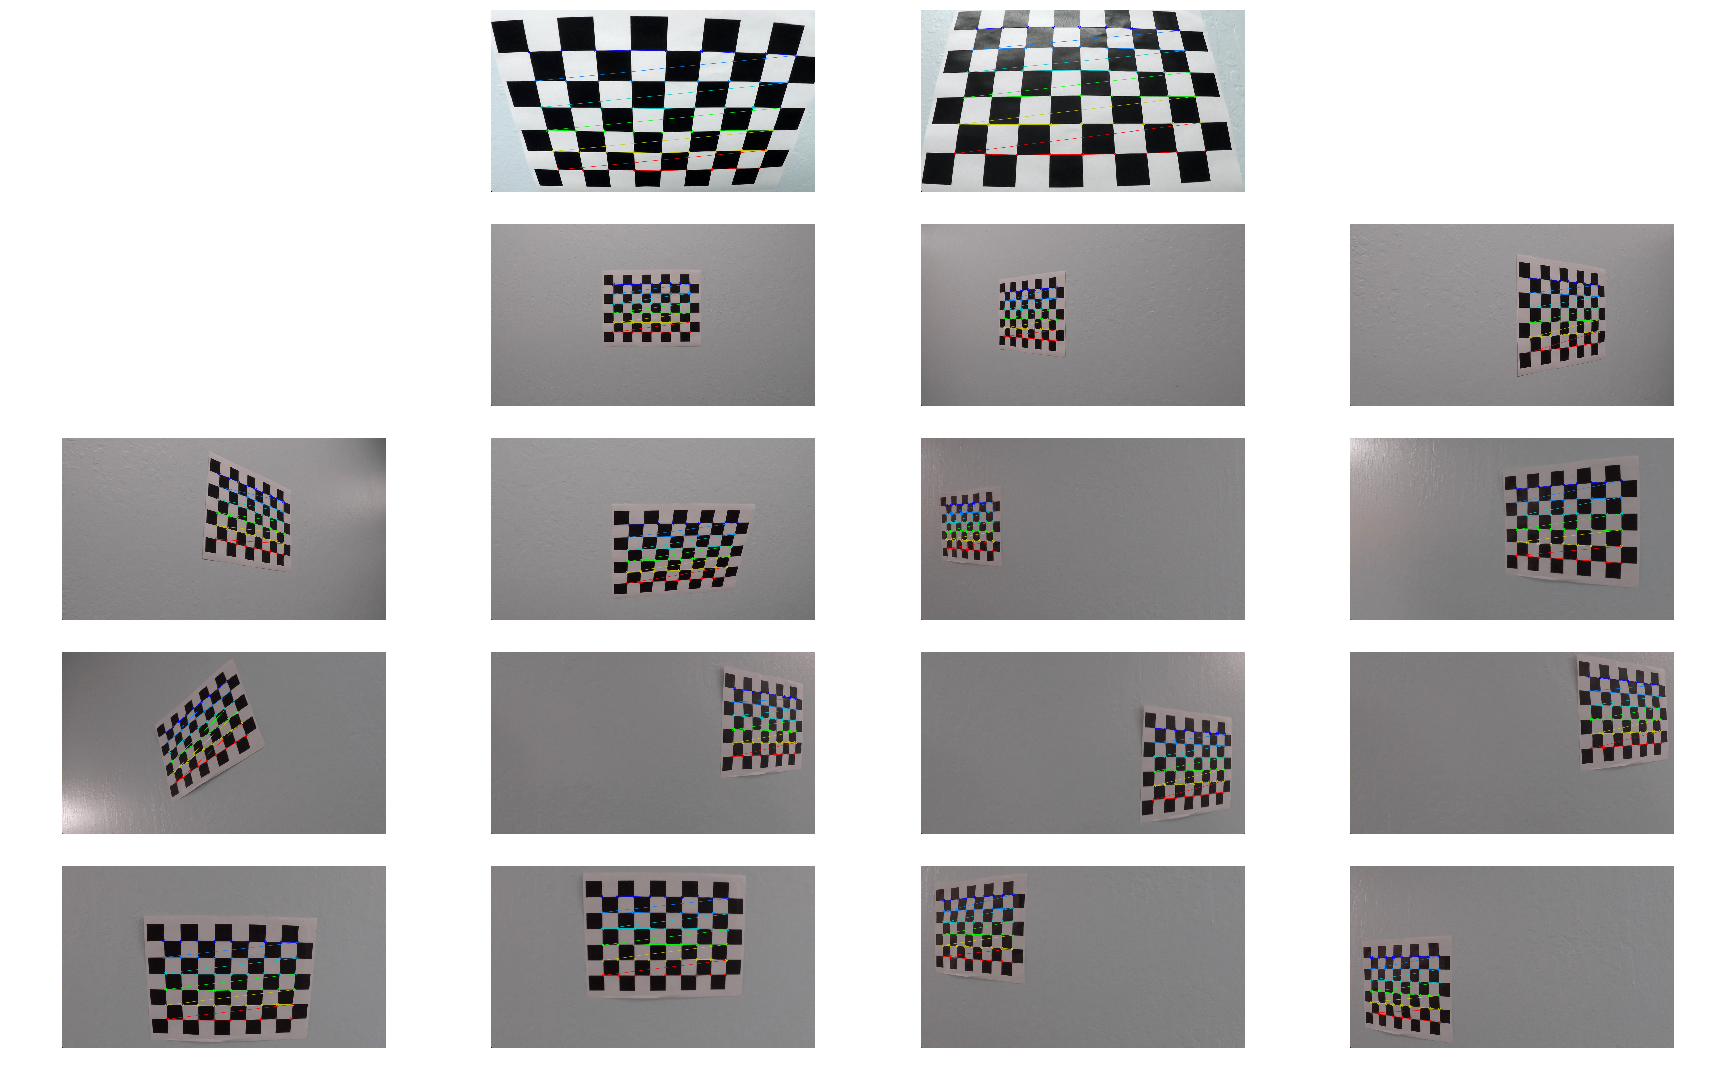

In [4]:
nx=9
ny=6
objp = np.zeros((ny*nx,3), dtype=np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
obj_points = []   # 3d points in real world space
img_points = []   # 2d points in image plane.
corner_images = []  # images with found corners

# Make a list of calibration images
fig, axs = plt.subplots(5, 4, figsize=(24, 15))
fig.tight_layout()

img_shape = None
for i, ax in enumerate(axs.ravel()):
    ax.axis("off")
    img = cv2.imread(os.path.join(CALIBRATION_DIR, "calibration{}.jpg".format(i+1)))
    if img_shape == None:
        img_shape = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    if ret:
        obj_points.append(objp)
        img_points.append(corners)
        corner_images.append(img)
        ax.imshow(img)

In [721]:
ret, CAMERA_MATRIX, DISTORTION_COEFFS, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_shape[::-1], None, None)
with open(CALIBRATION_FILE, "wb") as handle:
    np.save(handle, [CAMERA_MATRIX, DISTORTION_COEFFS])

print("Camera matrix")
print(CAMERA_MATRIX)
print("\nDistortion coefficients")
print(DISTORTION_COEFFS)

Camera matrix
[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

Distortion coefficients
[[ -2.41017956e-01  -5.30721170e-02  -1.15810353e-03  -1.28318860e-04
    2.67125310e-02]]


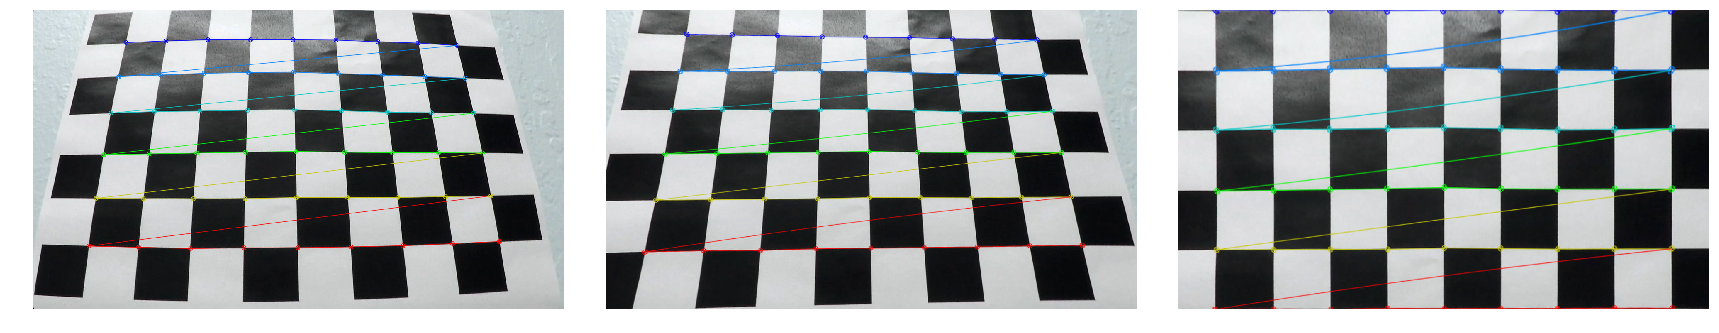

In [722]:
# Sanity check: Undistortion & Perspective Transform
fig, axs = plt.subplots(1, 3, figsize=(24, 10))
fig.tight_layout()

# undistort an image, and perspective warp first image for which perspective corners are found
for i, original_img in enumerate(corner_images):
    undistorted_img = cv2.undistort(original_img, CAMERA_MATRIX, DISTORTION_COEFFS)
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2GRAY)
    ret, undistorted_corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret:
        # get 4 corners for src polygon
        p0 = undistorted_corners[0]    # top left
        p1 = undistorted_corners[nx-1] # top right
        p2 = undistorted_corners[-1]   # bottom right
        p3 = undistorted_corners[-nx]  # bottom left
        src = np.concatenate((p0, p1, p2, p3))

        # define 4 destination points for perspective transform
        offset = 90
        rows, cols = img_shape
        dst = np.float32([[offset     , 0   ],
                          [cols-offset, 0   ],
                          [cols-offset, rows],
                          [offset     , rows]])

        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undistorted_img, M, (cols,rows), flags=cv2.INTER_LINEAR)

        ax1, ax2, ax3 = axs
        ax1.imshow(original_img)
        ax1.axis("off")
        ax2.imshow(undistorted_img)
        ax2.axis("off")
        ax3.imshow(warped)
        ax3.axis("off")
        break

In [1092]:
METERS_PER_PX_Y = 30. / 720. # meters per pixel in y dimension
METERS_PER_PX_X = 3.7 / 700. # meters per pixel in x dimension

class LaneDetector():
    def __init__(self,
                 show_diagnostics=False,
                 buffer_size=5,
                 num_search_windows=12,
                 search_window_margin=50,
                 minimum_search_pixels=50,
                 curve_line_width=25,
                 curve_error_thresh=1000.,
                 lane_width_error_thresh=1.,
                 lane_width_min=2.5,
                 lane_width_max=4.,
                 quad_top=.651,
                 quad_outer=.156,
                 quad_inner=.444,
                 quad_projection_offset=140):
        self.diagnostic_image = None
        self.show_diagnostics = show_diagnostics
        self.buffer_size = buffer_size
        self.left_lane_buffer = []
        self.right_lane_buffer = []
        self.left_curve_rad = 0.
        self.right_curve_rad = 0.
        self.curve_error = 0.
        self.curve_error_thresh = curve_error_thresh
        self.lane_width_top = 0.
        self.lane_width_bottom = 0.
        self.lane_width_error = 0.
        self.lane_width_error_thresh = lane_width_error_thresh
        self.lane_width_min = lane_width_min 
        self.lane_width_max = lane_width_max
        self.search_window_margin = search_window_margin
        self.num_search_windows = num_search_windows
        self.minimum_search_pixels = minimum_search_pixels
        self.curve_line_width = curve_line_width
        self.quad_top = quad_top
        self.quad_outer = quad_outer
        self.quad_inner = quad_inner
        self.quad_projection_offset = quad_projection_offset
    
    def undistort_image(self, img):
        """
        Remove camera distortion from image
        """
        return cv2.undistort(img, CAMERA_MATRIX, DISTORTION_COEFFS)

    def warp_image(self, img, src, dst, img_size):
        """
        Compute the perspective transformation from a source quadrangle to
        a destination and return the image with the perspective warp applied
        """
        M = cv2.getPerspectiveTransform(src, dst)
        return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    def get_quadrangles(self, rows, cols):
        """
        Define 2 quadrangles for perspective transformation
        """
        # define pseudo tilted plane
        top = rows * self.quad_top
        left_outer  = cols * self.quad_outer
        left_inner  = cols * self.quad_inner
        right_outer = cols * (1.-self.quad_outer)
        right_inner = cols * (1.-self.quad_inner)
        src = np.float32([[left_outer , rows],
                          [right_outer, rows],
                          [right_inner,  top],
                          [left_inner ,  top]])

        # define projected destination plane equivalent to bird's eye view of tilted plane
        dst = np.float32([[left_outer+self.quad_projection_offset , rows],
                          [right_outer-self.quad_projection_offset, rows],
                          [right_outer-self.quad_projection_offset,    0],
                          [left_outer+self.quad_projection_offset ,    0]])

        return src, dst
    
    def equalize_hist_hsv(self, img):
        h, s, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        return cv2.merge([h,s,clahe.apply(v)])
    
    def add_line_to_buffer(self, line, buffer):
        """
        Push the current line onto this buffer and drop the oldest line
        if there are more lines than the specified buffer size
        """
        buffer.append(line)
        return buffer[-self.buffer_size:]

    def filter_image_hsv(self, img):
        """
        Convert image to HSV color space and suppress any colors
        outside of the defined color ranges. Convert to binary img.
        """
        hsv = self.equalize_hist_hsv(img)
        yellow_dark = np.array([15, 127, 127], dtype=np.uint8)
        yellow_light = np.array([25, 255, 255], dtype=np.uint8)
        yellow_range = cv2.inRange(hsv, yellow_dark, yellow_light)

        white_dark = np.array([0, 0, 200], dtype=np.uint8)
        white_light = np.array([255, 30, 255], dtype=np.uint8)
        white_range = cv2.inRange(hsv, white_dark, white_light)

        filtered = cv2.bitwise_and(hsv, hsv, mask=(yellow_range | white_range))
        return filtered[:,:,2] # only keep the "value" channel of the image
    
    def binary_image(self, img, thresh=(0, 255)):
        binary_output = np.zeros_like(img)
        binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
        return binary_output
    
    def get_base_xs(self, img):
        """
        Sum the columns and find the peak of the left and right halves of the histogram
        These will be the starting point for the left and right lines
        """
        mid_y = int(img.shape[0]/2)
        mid_x = int(img.shape[1]/2)
        histogram = np.sum(img[mid_y:,:], axis=0)
        left_x = np.argmax(histogram[:mid_x])
        right_x = np.argmax(histogram[mid_x:]) + mid_x
        return left_x, right_x
    
    def solve_for_x(self, curve_coeffs, y_vals):
        """
        Given a set of y-values, return the corresponding x-values,
        based on the polynomial coefficients contained in `curve_coeffs`
        """
        fn = np.poly1d(curve_coeffs)
        return fn(y_vals)
    
    def merge_x_and_y(self, x, y, invert=False):
        """
        Re-combine the x and y values of points
        """
        merged = np.vstack([x, y]).T
        return np.flipud(merged) if invert else merged
    
    def get_curve_radius(self, points, y_val=360):
        """
        Rescale polynomial values to meters in x,y.
        Compute curve radius in meters.
        """
        y_val *= METERS_PER_PX_Y
        A, B, C = np.polyfit(points[:,1]*METERS_PER_PX_Y, points[:,0]*METERS_PER_PX_X, 2)

        # Calculate the radius of curvature at the given y value
        return (1 + (2*A*y_val + B)**2)**1.5 / np.abs(2*A)
    
    def get_lane_widths(self, x_left, x_right):
        """
        Measure the distance in meters between the
        top and bottom values of the lane lines.
        """
        top_width = (x_right[0] - x_left[0]) * METERS_PER_PX_X
        bottom_width = (x_right[-1] - x_left[-1]) * METERS_PER_PX_X
        return top_width, bottom_width
    
    def get_curve_error(self, x_left, x_right):
        """
        Measure the difference between the 2 curves
        """
        if len(x_left) == 0 or len(x_right) == 0:
            return float('inf')
        
        # Compute the difference between the last x values of the left and right lanes
        x_diff = x_right[-1] - x_left[-1]
        
        # Translate the right lane so that the left and right lanes both have the same base x value
        x_right_prime = x_right - x_diff
        
        # Return sum of squared error to quantify the difference in the curves
        return np.sqrt(np.sum((x_left-x_right_prime)**2))
    
    def sanity_check(self, x_left, x_right):
        """
        Only keep those lanes that meet the following criteria.
        """
        # Check that lanes have similar curvature
        self.curve_error = self.get_curve_error(x_left, x_right)
        if self.curve_error > self.curve_error_thresh:
            return False

        # Check that lanes are roughly parallel
        self.lane_width_top, self.lane_width_bottom = self.get_lane_widths(x_left, x_right)
        self.lane_width_error = abs(self.lane_width_top - self.lane_width_bottom)
        if self.lane_width_error > self.lane_width_error_thresh:
            return False

        # Checking that they are separated by approximately the right distance horizontally
        if ((self.lane_width_top < self.lane_width_min) or
            (self.lane_width_top > self.lane_width_max) or
            (self.lane_width_bottom < self.lane_width_min) or
            (self.lane_width_bottom > self.lane_width_max)):
            return False
        
        # All checks pass
        return True

    def lookahead_search(self, img, curve_coeffs, x_vals, hide_visualization=False):
        y_vals = np.linspace(0, img.shape[0]-1, x_vals.shape[0])
        x_curve = self.solve_for_x(curve_coeffs, y_vals)
        
        if self.show_diagnostics and not hide_visualization:
            line_img = np.zeros_like(self.diagnostic_image)
            line = self.merge_x_and_y(x_curve, y_vals)
            cv2.polylines(line_img, [line.astype(int)], False, (0,255,255), self.search_window_margin*2)
            cv2.addWeighted(self.diagnostic_image, 1, line_img, 0.5, 0, self.diagnostic_image)

        return ((x_vals >= (x_curve-self.search_window_margin)) & (x_vals < (x_curve+self.search_window_margin)))

    def sliding_window_search(self, img, initial_x, y_vals, x_vals, hide_visualization):
        """
        Re-combine the x and y values of points
        """
        rows, cols = img.shape
        
        # height of sliding windows
        win_height = int(rows/self.num_search_windows)

        # store lane pixel indices
        indices = []

        # set the first x position to the initial x
        current_x = initial_x
        for y in reversed(range(0, rows, win_height)):
            # window boundaries
            y_lower = y
            y_upper = y + win_height
            x_left = current_x - self.search_window_margin
            x_right = current_x + self.search_window_margin

            # Draw the windows on the diagnostic image
            if self.show_diagnostics and not hide_visualization:
                cv2.rectangle(self.diagnostic_image, (x_left,y_lower), (x_right,y_upper), (0,200,200), 2)

            # Identify the nonzero pixels in x and y within the window
            found_indices = ((y_vals >= y_lower) & (y_vals < y_upper) &
                             (x_vals >= x_left) & (x_vals < x_right)).nonzero()[0]

            # Append these indices to the lists
            indices.append(found_indices)

            # if found > self.minimum_search_pixels, recenter next window on their mean position
            if len(found_indices) >= self.minimum_search_pixels:
                current_x = int(np.mean(x_vals[found_indices]))

        # Concatenate and return the found indices
        return np.concatenate(indices) 

    def get_lane_points(self, img, initial_x_val, y_vals, x_vals, lane_buffer, hide_visualization=False):
        if len(lane_buffer) > 0:
            curve_coeffs = np.mean(lane_buffer, axis=0)
            indices = self.lookahead_search(img, curve_coeffs, x_vals, hide_visualization)
        else:
            indices = self.sliding_window_search(img, initial_x_val, y_vals, x_vals, hide_visualization)

        # Extract x and y pixel coordinates
        points = {"X": x_vals[indices], "Y": y_vals[indices]}
        
        # highlight the identified pixels
        if self.show_diagnostics:
            self.diagnostic_image[points["Y"], points["X"], :] = (0,190,0)
        
        return points
    
    def fit_curve_to_points(self, points, y_vals):
        """
        fit a curve to the set of points and return the x values and curve coefficients
        """
        x_vals = np.array([])
        curve_coeffs = np.array([])
        if len(points["X"]) > 1 and len(points["Y"]) > 1:
            curve_coeffs = np.polyfit(points["Y"], points["X"], 2)
            x_vals = self.solve_for_x(curve_coeffs, y_vals)
        return x_vals, curve_coeffs

    def get_curves(self, img, hide_visualization=False):
        nonzero_y, nonzero_x = img.nonzero()
        base_x_left, base_x_right = self.get_base_xs(img)

        points_left = self.get_lane_points(img, base_x_left, nonzero_y, nonzero_x, self.left_lane_buffer,
                                          hide_visualization=hide_visualization)
        points_right = self.get_lane_points(img, base_x_right, nonzero_y, nonzero_x, self.right_lane_buffer,
                                           hide_visualization=hide_visualization)

        # y values for drawing the curves
        y_vals = np.linspace(0, img.shape[0]-1, img.shape[0])
        
        # get current x_coords and curve coefficients for sanity check
        x_left, curve_coeffs_left = self.fit_curve_to_points(points_left, y_vals)
        x_right, curve_coeffs_right = self.fit_curve_to_points(points_right, y_vals)
        
        # if current x_coords pass sanity check, store curve coefficients in lane buffers
        if self.sanity_check(x_left, x_right):
            self.left_lane_buffer = self.add_line_to_buffer(curve_coeffs_left, self.left_lane_buffer)
            self.right_lane_buffer = self.add_line_to_buffer(curve_coeffs_right, self.right_lane_buffer)
        
        # Get the mean curve coefficients from the lane buffer to draw the real curve
        mean_curve_coeffs_left = np.mean(self.left_lane_buffer, axis=0)
        x_left = self.solve_for_x(mean_curve_coeffs_left, y_vals)

        mean_curve_coeffs_right = np.mean(self.right_lane_buffer, axis=0)
        x_right = self.solve_for_x(mean_curve_coeffs_right, y_vals)
        
        curve_left = self.merge_x_and_y(x_left, y_vals)
        self.left_curve_rad = self.get_curve_radius(curve_left)

        curve_right = self.merge_x_and_y(x_right, y_vals, invert=True)
        self.right_curve_rad = self.get_curve_radius(curve_right)

        if self.show_diagnostics and not hide_visualization:
            cv2.polylines(self.diagnostic_image, [curve_left.astype(int)], False, (255,0,0), 5)
            cv2.polylines(self.diagnostic_image, [curve_right.astype(int)], False, (255,0,0), 5)
        return curve_left, curve_right
    
    def draw_curves(self, img):
        curve_image = np.zeros(img.shape + (3,), dtype=np.uint8)

        curve_left, curve_right = self.get_curves(img)
        curve_poly = np.vstack((curve_left, curve_right))

        cv2.polylines(curve_image, [curve_left.astype(int)], False, (255,255,0), self.curve_line_width)
        cv2.polylines(curve_image, [curve_right.astype(int)], False, (255,255,0), self.curve_line_width)
        cv2.fillPoly(curve_image, [curve_poly.astype(int)], (0,255,255))
        return curve_image
    
    def print_info(self, img):
        text_color = lambda n, thresh: (190,0,0) if n > thresh else (0,100,0)

        info = [("Left  Rad: {:.1f} m".format(self.left_curve_rad), (0,0,0)),
                ("Right Rad: {:.1f} m".format(self.right_curve_rad), (0,0,0)),
                ("Top Width: {0:.3f} m".format(self.lane_width_top), (0,0,0)),
                ("Bot Width: {0:.3f} m".format(self.lane_width_bottom), (0,0,0)),
                ("Lane Width Error: {:.3f}".format(self.lane_width_error), text_color(self.lane_width_error,
                                                                                      self.lane_width_error_thresh)),
                ("Curve Match Error: {0:.2f}".format(self.curve_error), text_color(self.curve_error,
                                                                                   self.curve_error_thresh)),]

        y0, dy = 35, 40
        for i, line in enumerate(info):
            text, color = line
            cv2.putText(img, text, (15, y0 + i*dy), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    
    def assemble_diagnostic_screen(self, img, warped, curves):
        right = np.vstack((warped, self.diagnostic_image))
        right = cv2.resize(right, (640,720), interpolation=cv2.INTER_AREA)
        return np.hstack((img, right))
    
    def process_frame(self, img):
        rows, cols = img.shape[:2]
        src_quad, dst_quad = ld.get_quadrangles(rows, cols)
        undistorted = self.undistort_image(img)
        warped = self.warp_image(undistorted, src_quad, dst_quad, (cols,rows))
        filtered = self.filter_image_hsv(warped)
        binary = self.binary_image(filtered)
        if self.show_diagnostics:
            self.diagnostic_image = np.dstack((binary,binary,binary)) * 127
        curves = self.draw_curves(binary)
        unwarped_curves = self.warp_image(curves, dst_quad, src_quad, (cols,rows))
        img = cv2.addWeighted(undistorted, 1, unwarped_curves, 0.5, 0)
        if self.show_diagnostics:
            img = self.assemble_diagnostic_screen(img, warped, curves)
        self.print_info(img)
        return img

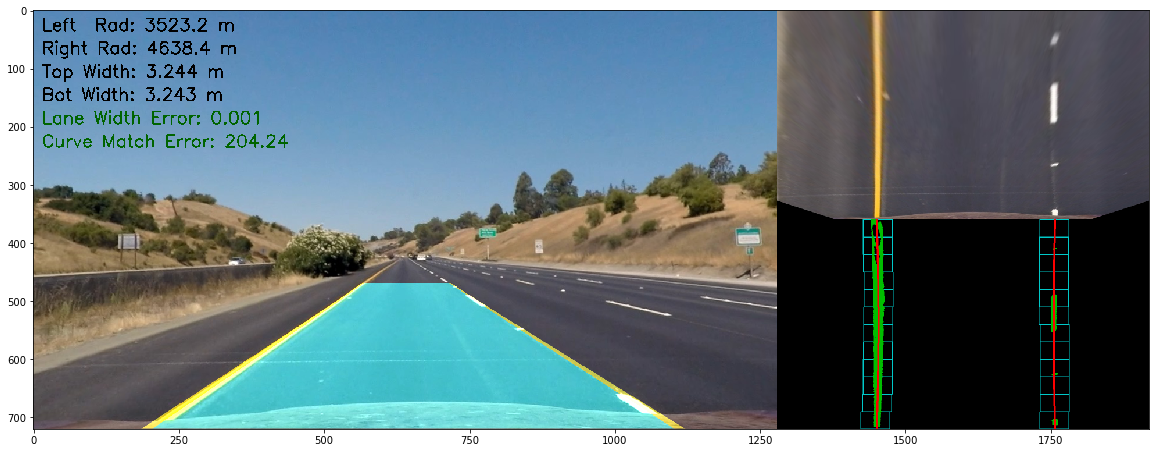

In [1084]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im = mpimg.imread(os.path.join(TEST_DIR, "straight_lines{}.jpg".format(1)))
ld = LaneDetector(show_diagnostics=True,
                  num_search_windows=12,
                  search_window_margin=50,
                  minimum_search_pixels=50,
                  curve_line_width=25)
ax.imshow(ld.process_frame(im))

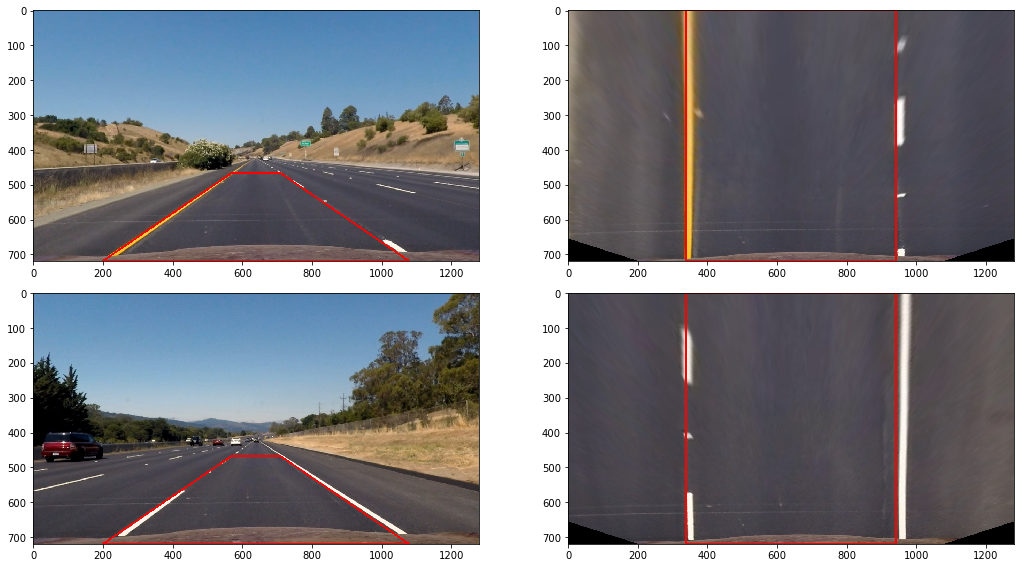

In [1070]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
fig.tight_layout()
for i, row in enumerate(axs):
    ld = LaneDetector(quad_top=.651,
                      quad_outer=0.156,
                      quad_inner=0.444,
                      quad_projection_offset=140)
    ax1, ax2 = row
    image = mpimg.imread(os.path.join(TEST_DIR, "straight_lines{}.jpg".format(i+1)))
    rows, cols = image.shape[:2]
    src, dst = ld.get_quadrangles(rows, cols)
    undistorted = ld.undistort_image(image)
    warped = ld.warp_image(undistorted, src, dst, (cols,rows))
    cv2.polylines(undistorted, [src.astype(int)], True, (255,), 4)
    cv2.polylines(warped, [dst.astype(int)], True, (255,), 4)
    ax1.imshow(undistorted)
    ax2.imshow(warped)

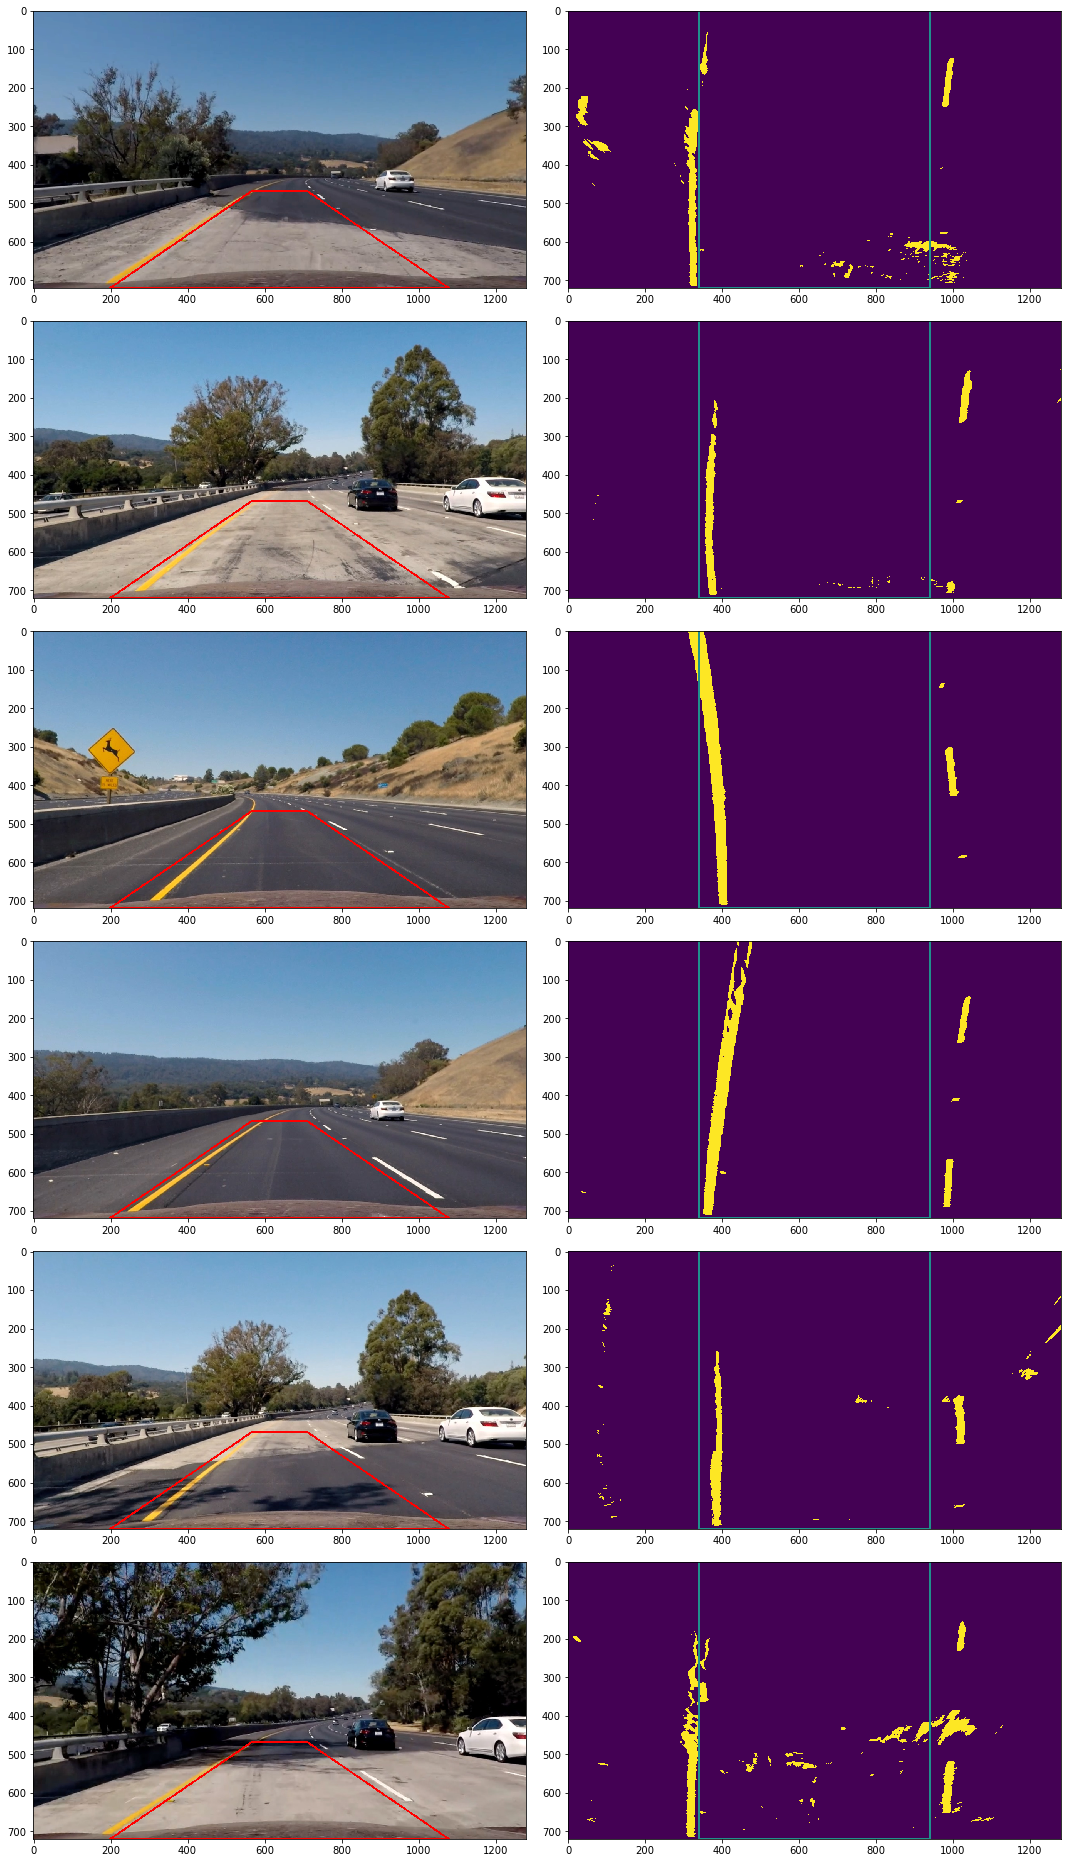

In [1071]:
fig, axs = plt.subplots(6, 2, figsize=(15, 26))
fig.tight_layout()
for i, row in enumerate(axs):
    ld = LaneDetector()
    ax1, ax2 = row
    image = mpimg.imread(os.path.join(TEST_DIR, "test{}.jpg".format(i)))
    rows, cols = image.shape[:2]
    src, dst = ld.get_quadrangles(rows, cols)
    undistorted = ld.undistort_image(image)
    warped = ld.warp_image(undistorted, src, dst, (cols,rows))
    filtered = ld.filter_image_hsv(warped)
    binary = ld.binary_image(filtered) * 2
    cv2.polylines(undistorted, [src.astype(int)], True, (255,), 4)
    cv2.polylines(binary, [dst.astype(int)], True, (1,), 4)
    ax1.imshow(undistorted)
    ax2.imshow(binary)

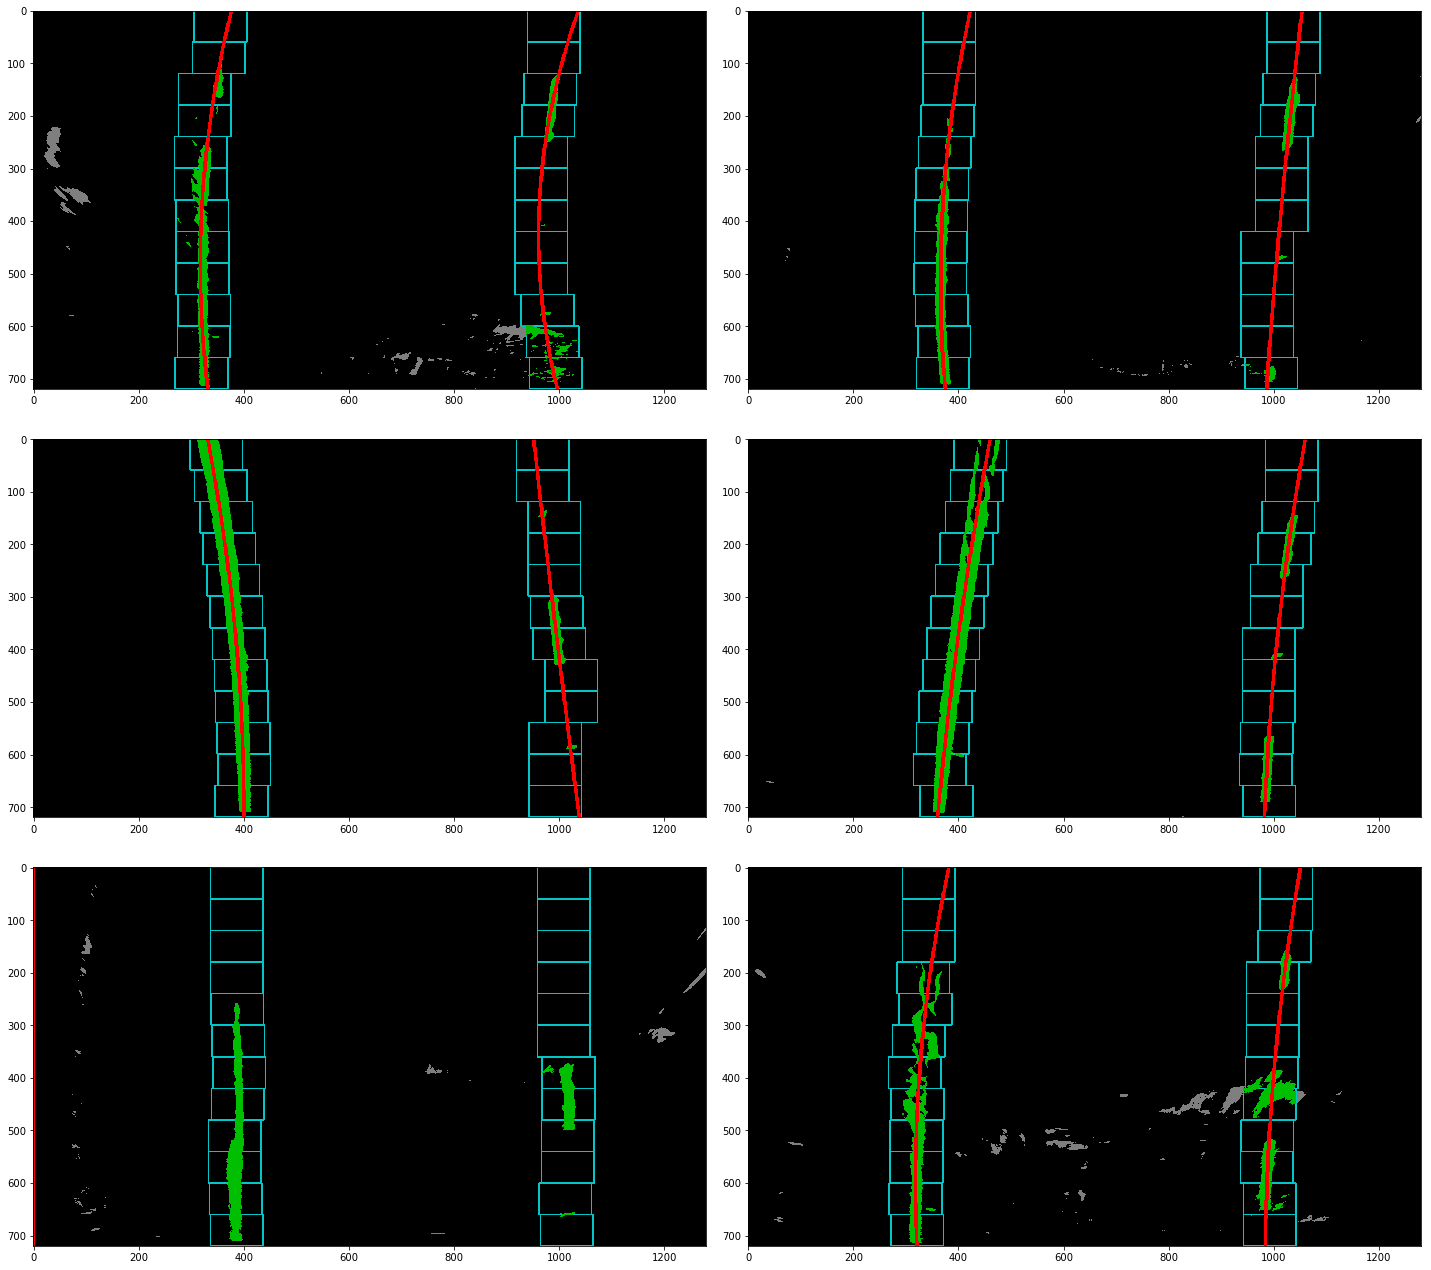

In [1072]:
fig, axs = plt.subplots(3, 2, figsize=(20, 18))
fig.tight_layout()
for i, ax in enumerate(axs.ravel()):
    ld = LaneDetector(show_diagnostics=True)
    image = mpimg.imread(os.path.join(TEST_DIR, "test{}.jpg".format(i)))
    rows, cols = image.shape[:2]
    src, dst = ld.get_quadrangles(rows, cols)
    undistorted = ld.undistort_image(image)
    warped = ld.warp_image(undistorted, src, dst, (cols,rows))
    filtered = ld.filter_image_hsv(warped)
    binary = ld.binary_image(filtered)
    ld.diagnostic_image = np.dstack((binary,binary,binary)) * 127
    ld.get_curves(binary)
    ax.imshow(ld.diagnostic_image)

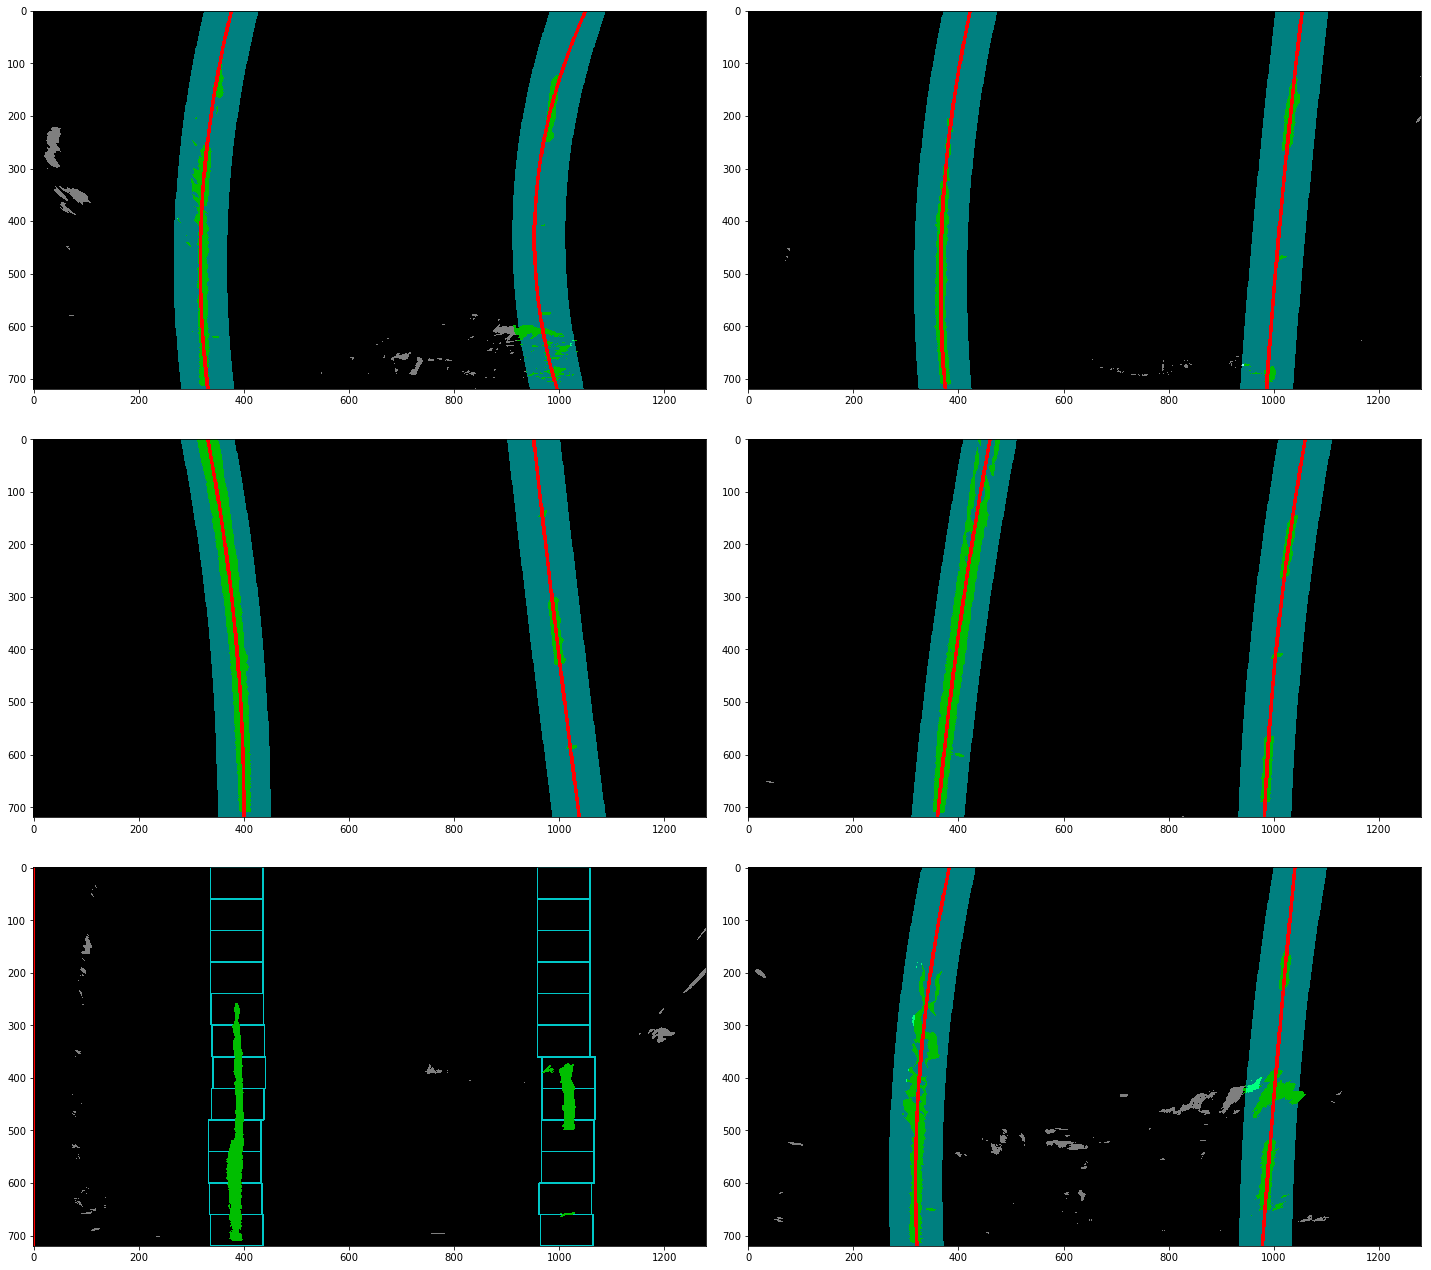

In [1073]:
fig, axs = plt.subplots(3, 2, figsize=(20, 18))
fig.tight_layout()
for i, ax in enumerate(axs.ravel()):
    ld = LaneDetector(show_diagnostics=True)
    image = mpimg.imread(os.path.join(TEST_DIR, "test{}.jpg".format(i)))
    rows, cols = image.shape[:2]
    src, dst = ld.get_quadrangles(rows, cols)
    undistorted = ld.undistort_image(image)
    warped = ld.warp_image(undistorted, src, dst, (cols,rows))
    filtered = ld.filter_image_hsv(warped)
    binary = ld.binary_image(filtered)
    ld.diagnostic_image = np.dstack((binary,binary,binary)) * 127
    # run get_curves twice to force fit values onto lookahead search for visualization purposes
    ld.get_curves(binary, hide_visualization=True)
    ld.get_curves(binary)
    ax.imshow(ld.diagnostic_image)

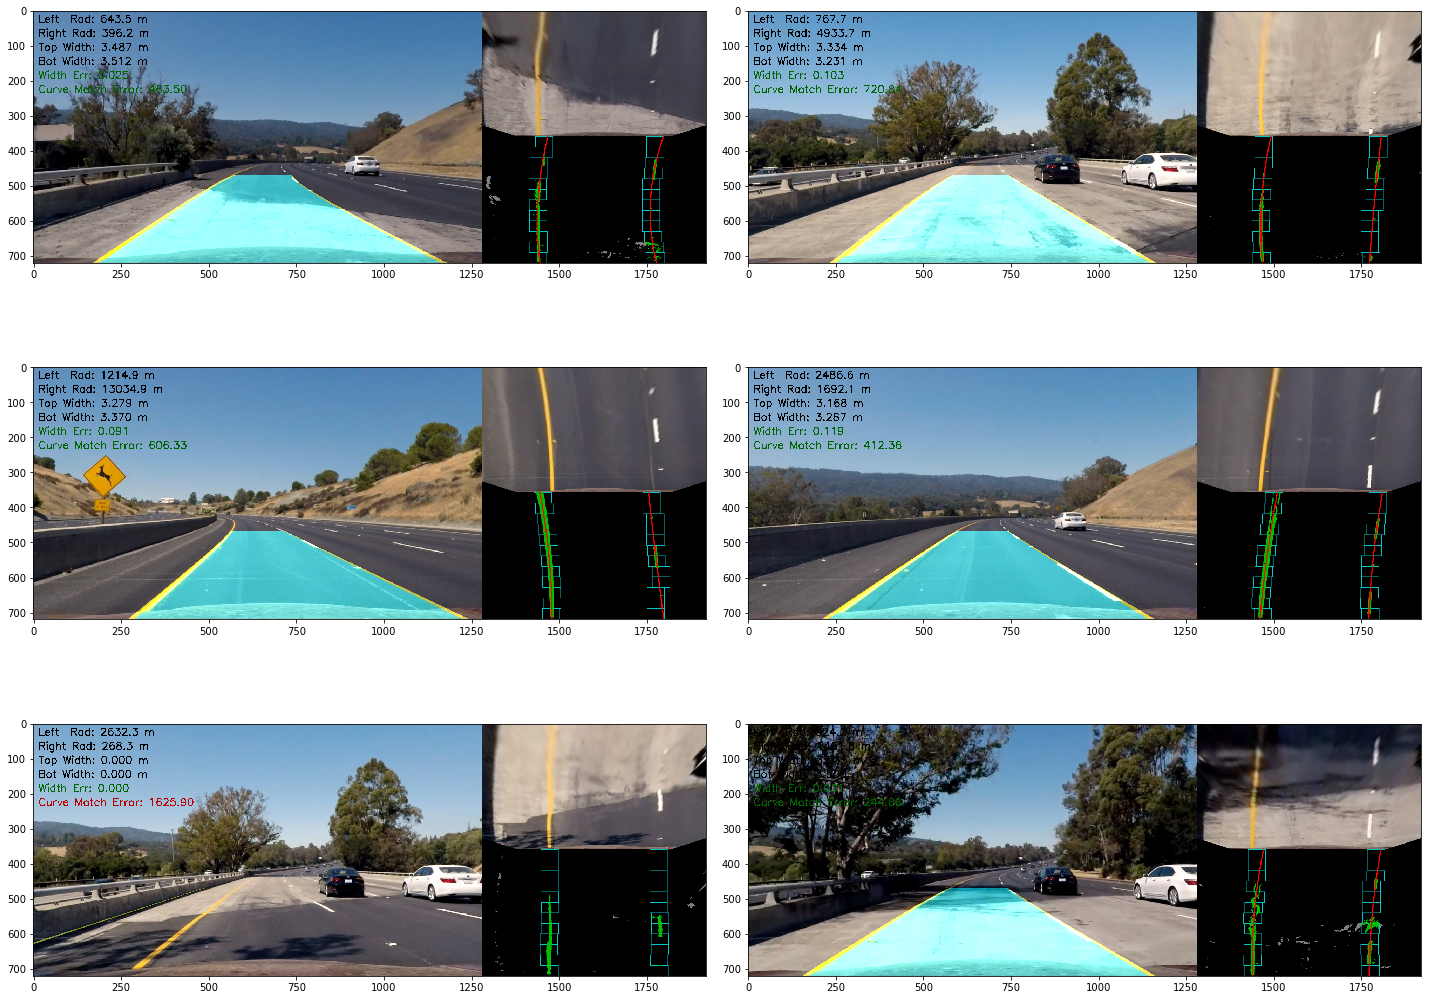

In [1074]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
fig.tight_layout()
for i, ax in enumerate(axs.ravel()):
    ld = LaneDetector(show_diagnostics=True)
    image = mpimg.imread(os.path.join(TEST_DIR, "test{}.jpg".format(i)))
    ax.imshow(ld.process_frame(image))

In [90]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [1120]:
ld = LaneDetector(show_diagnostics=False)

output1 = 'project_video_process.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(ld.process_frame)
%time project_clip.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video project_video_process.mp4
[MoviePy] Writing video project_video_process.mp4



100%|█████████▉| 1260/1261 [01:52<00:00,  9.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_process.mp4 

CPU times: user 3min 9s, sys: 19.8 s, total: 3min 29s
Wall time: 1min 53s


In [1121]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output1))

In [ ]:
ld = LaneDetector(show_diagnostics=True)

output1 = 'project_video_diagnostic.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(ld.process_frame)
%time project_clip.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video project_video_diagnostic.mp4
[MoviePy] Writing video project_video_diagnostic.mp4



 25%|██▍       | 312/1261 [06:38<21:20,  1.35s/it]

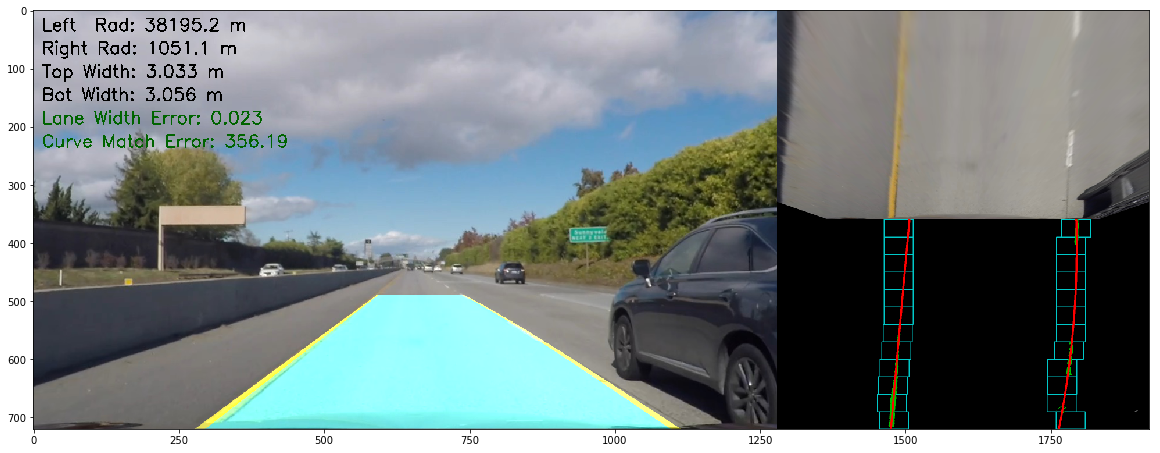

In [1117]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
im = mpimg.imread(os.path.join(TEST_DIR, "straight_lines_advanced{}.jpg".format(1)))
ld = LaneDetector(show_diagnostics=True,
                  quad_top=.68,
                  quad_outer=0.163,
                  quad_inner=0.439,
                  quad_projection_offset=120)
ax.imshow(ld.process_frame(im))

In [1118]:
ld = LaneDetector()

output2 = 'challenge_video_process.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(ld.process_frame)
%time challenge_clip.write_videofile(output2, audio=False)

[MoviePy] >>>> Building video challenge_video_process.mp4
[MoviePy] Writing video challenge_video_process.mp4



100%|██████████| 485/485 [00:38<00:00, 12.76it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_process.mp4 

CPU times: user 1min 6s, sys: 6.7 s, total: 1min 13s
Wall time: 38.7 s


In [1119]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))